First we will make sure ***gensim*** (for text-preprocessing), ***imbalanced-learn*** (for oversampling/undersampling methods), and ***textblob*** (for some basic sentiment analysis) are installed.

In [1]:
!pip install gensim
!pip install imbalanced-learn
!pip install textblob

    100% |████████████████████████████████| 23.6MB 1.8MB/s 
    100% |████████████████████████████████| 1.4MB 15.1MB/s 
    100% |████████████████████████████████| 133kB 21.7MB/s 
    100% |████████████████████████████████| 61kB 23.3MB/s 
    100% |████████████████████████████████| 4.8MB 7.2MB/s 
    100% |████████████████████████████████| 552kB 25.2MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
    100% |████████████████████████████████| 174kB 5.1MB/s 
    100% |████████████████████████████████| 5.3MB 5.5MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2
    100% |███

Let's now import some important libraries' features.

In [0]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import preprocess_string
from time import time
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import ttest_ind


Now, let's load our train and test data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/knoesis/prog_task/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/knoesis/prog_task/test.csv')
train.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Just to get a feel of how many bad comments there are, let's add another column *'any'*, which denotes that a comment has a label of *'toxic'*, *'severe_toxic'*, *'obscene'*, *'threat'*, *'insult'* or *'identity_hate'*. We will not train a model to predict this, it just helps us make certain conclusions.

In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train['any'] = train[labels].any(axis = 'columns').astype(int)
labels.append('any')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,any
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


[Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) are a powerful feature of scikit-learn that help cleanly abstractify the steps in a Data Science pipeline.

Some great introductions to them can be found [here](https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines#), [here](https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/) and [here](http://michelleful.github.io/code-blog/2015/06/20/pipelines/). We will create pipelines for preprocessing comments and feature generation. The features we are considering are tf-idf vectors (in the space of the training dataset), the length of preprocessed comments and the TextBlob sentiment score of preprocessed comments.

The reason for including these features will be explained further below. For now, just try to understand the following code.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


class Transformer(BaseEstimator, TransformerMixin):
    '''
    Parent Class for any other Transformer. The fit() and transform() methods are important for Pipelining.
    '''
    def __init__(self, key):
        self.key = key
    
    def transform_function(self, s):
        return s

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key].apply(self.transform_function)


class PreprocessTransformer(Transformer):
    '''
    Transformer get a preprocessed comment.
    '''
    def transform_function(self, s):
        return ' '.join(preprocess_string(s))


class WordCountTransformer(Transformer):
    '''
    Transformer to get the number of words in a comment.
    '''
    def transform_function(self, s):
        return float(len(s.split(' ')))
    
    def transform(self, X):
        return X[self.key].apply(self.transform_function).values.reshape(-1,1) # Numeric columns need a different transform


class SentimentScoreTransformer(Transformer):
    '''
    Transformer to get the sentiment score of a comment.
    '''
    def transform_function(self, s):
        return TextBlob(s).sentiment.polarity
    
    def transform(self, X):
        return X[self.key].apply(self.transform_function).values.reshape(-1,1) # Numeric columns need a different transform


preprocessPipeline = Pipeline([
    ('preprocess', PreprocessTransformer(key = 'comment_text'))
])

wordCountPipeline = Pipeline([
    ('word count', WordCountTransformer(key = 'comment_text')),
    ('scaler', StandardScaler())
])

sentimentScorePipeline = Pipeline([
    ('sentiment score', SentimentScoreTransformer(key = 'comment_text')),
    ('scaler', StandardScaler())
])

tfidfPipeline = Pipeline([
    ('selector', Transformer(key = 'comment_text')), # the parent class acts as a selector
    ('vectorizer', TfidfVectorizer(use_idf=1, smooth_idf=1, sublinear_tf=1, ngram_range = (1,2), max_features = 300000))
])

featureUnion = FeatureUnion([
    ('word count', wordCountPipeline),
    ('sentiment score', sentimentScorePipeline),
    ('tfidf', tfidfPipeline)
])

featurePipeline = Pipeline([('features', featureUnion)])

We need to preprocess every comment before we perform any exploratory data analysis and eventually develop a model. Removing stop words might not be needed for some steps of our data analysis, but we'll do it anyway assuming that stop words don't add any meaning to our dataset.

*Gensim* has a great built in [function](https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string) to do so, which:

1.   strips tags
2.   strips punctuation
3.   strips multiple whitespaces
4.   strips numbers
5.   removes stopwords (which usually carry insignificant semantic value)
6.   strips short words (default min size is 3)
7.   stems text (to make sure that, say,  'pony' and 'ponies' register as the same word)

Note that we are converting the preprocessed string (a python list) back to a string because that is the required input for *scikit-learn'*s *TfidfVectorizer*.

In [6]:
train['comment_text'] = preprocessPipeline.fit_transform(train)
train['comment_text'].dropna(how = 'any', inplace = True)

test['comment_text'] = preprocessPipeline.fit_transform(test)
test['comment_text'].dropna(how = 'any', inplace = True)

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,any
0,0000997932d777bf,explan edit usernam hardcor metallica fan reve...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seemingli stuck th...,0,0,0,0,0,0,0
2,000113f07ec002fd,hei man try edit war gui constantli remov rele...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,real suggest improv wonder section statist lat...,0,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page,0,0,0,0,0,0,0


Let's look at the most common words in each category of comments.

Note that we are doing so after preprocessing, so some words might look odd. Don't worry, they are just in their stemmed form.

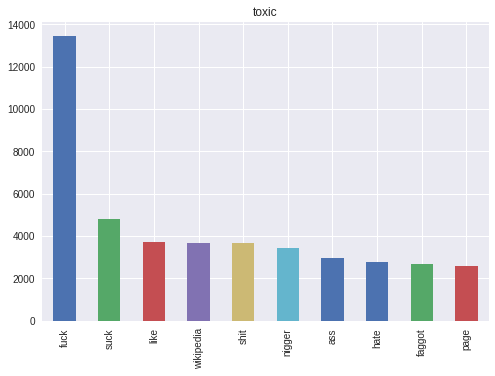

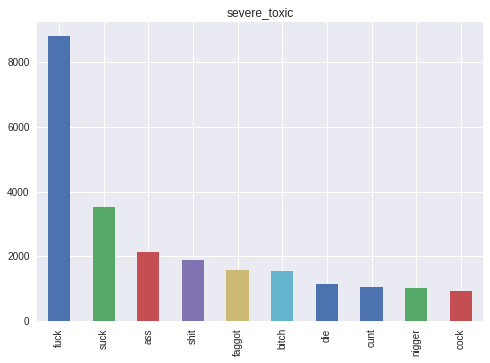

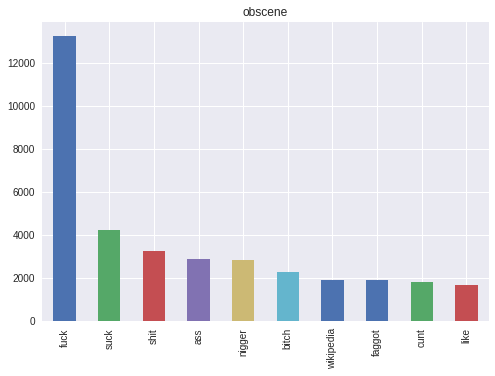

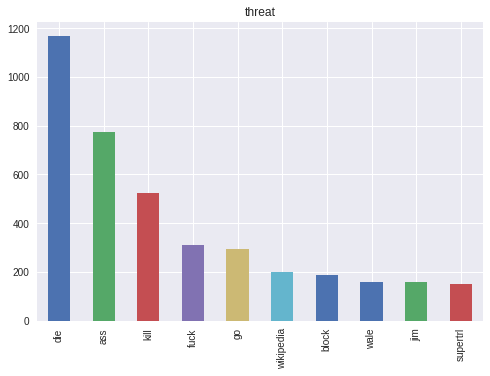

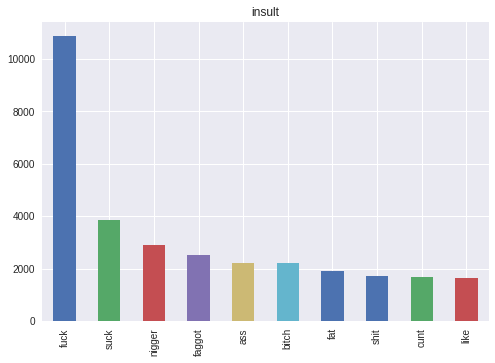

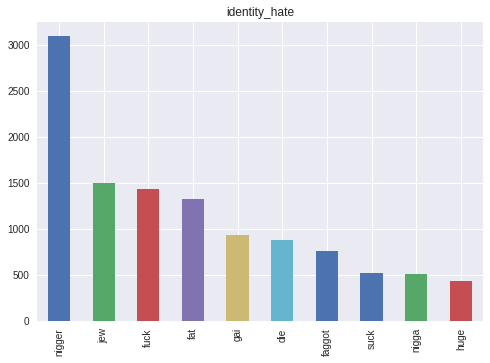

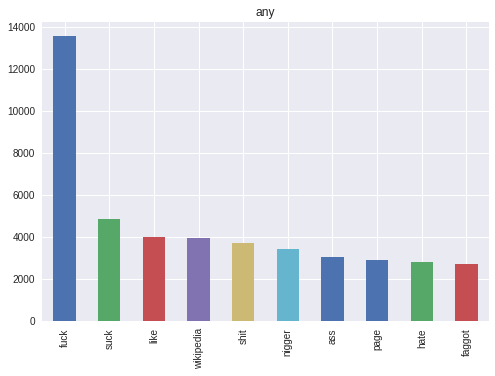

In [7]:
for label in labels:
    top10words = pd.Series(' '.join(train.loc[train[label] > 0]['comment_text']).split()).value_counts()[:10]
    top10words.plot.bar()
    plt.title(label)
    plt.show()
    plt.clf()

As expected, most words are expletives.
Interestingly, *'threat'* and *'identity_hate'* seem to follow (slightly) different trends compared to the rest in terms of which words are most frequent.


---


Now, let's try and see if there is any significant difference between the mean number of words in good and bad comments of each category. We'll use an independant t-test with the assumption that the two populations (good comments and bad comments) have equal variances.

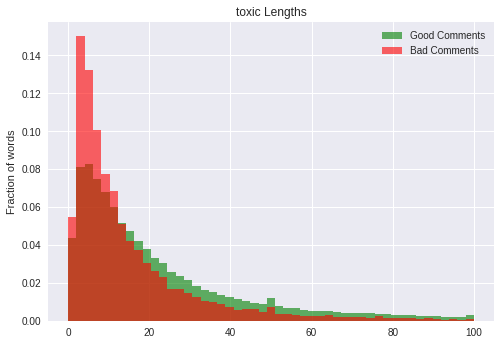

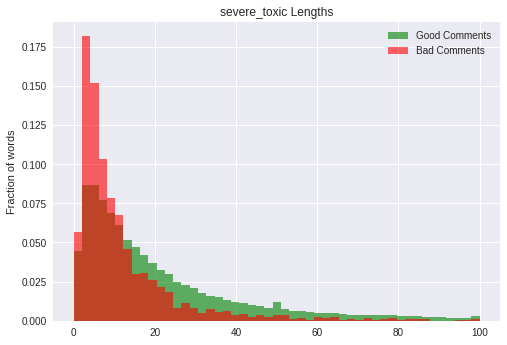

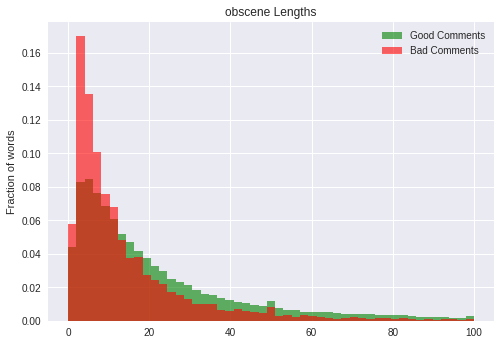

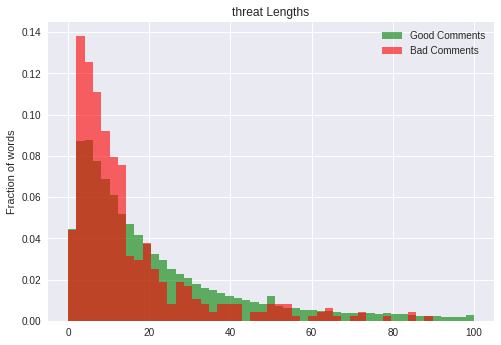

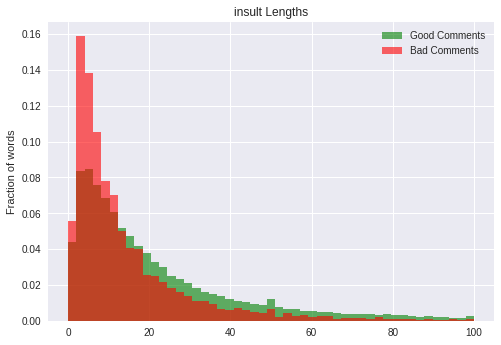

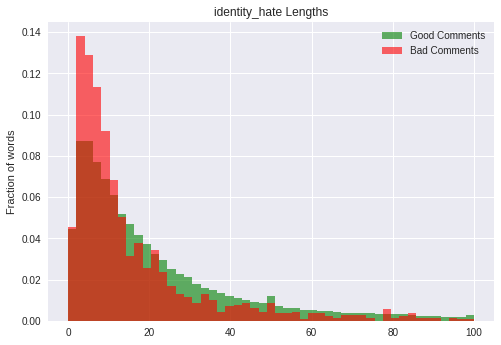

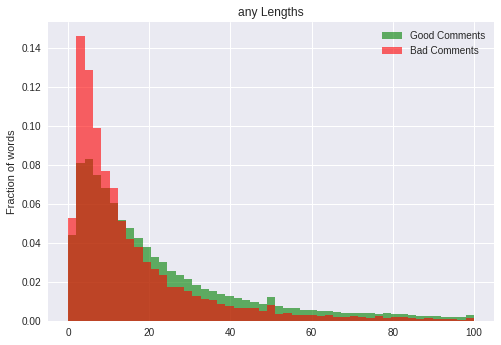

Is the p-value less than 0.05 - {'toxic': True, 'severe_toxic': True, 'obscene': True, 'threat': False, 'insult': True, 'identity_hate': False, 'any': True}


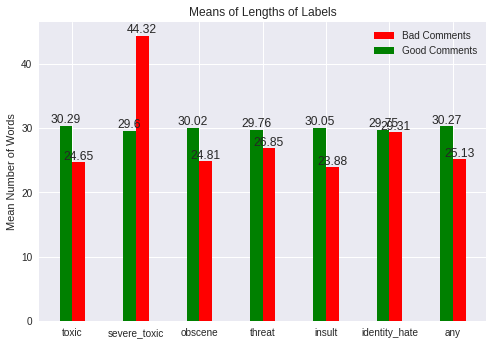

In [9]:
def plot_double_bar(greenVals, redVals, title):
    '''
    Function to display two bars for each category in one chart.
    '''
    # Plot bar graph
    ind = np.arange(len(labels))
    width = 0.2

    fig = plt.figure()
    ax = fig.add_subplot(111)

    rects1 = ax.bar(ind + width, badMeans, width, color='r')
    rects2 = ax.bar(ind, goodMeans, width, color='g')

    ax.set_ylabel('Mean Number of Words')
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels( labels )
    ax.legend( (rects1[0], rects2[0]), ('Bad Comments', 'Good Comments') )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.001*h, round(h, 2), ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.title(title)
    plt.show()
    plt.clf()


def plot_double_dist(minX, maxX, goodVals, badVals, title):
    '''
    Function to show the frequencies of two sets of values on the same chart.
    '''
    plt.title(title)
    bins = np.linspace(minX, maxX, 50)

    # the weights option is so that the distrubution is not unbalanced due to the huge difference in number of good and bad comments
    plt.hist(goodVals, bins, alpha=0.6, color = 'green', weights=np.zeros_like(goodVals) + 1. / goodVals.size, label='Good Comments')
    plt.hist(badVals, bins, alpha=0.6, color = 'red', weights=np.zeros_like(badVals) + 1. / badVals.size, label='Bad Comments')
    
    plt.ylabel('Fraction of words')
    plt.legend(loc='upper right')
    plt.show()
    plt.clf()


# Find mean lengths for good/bad comments of each category
train['num_words'] = train['comment_text'].apply(lambda x: len(x.split(' '))) # we aren't using the pipeline because we don't want to scale
goodMeans, badMeans = [], []
pVals = {}
for label in labels:
    good = train[train[label] == 0]
    bad = train[train[label] == 1]
    t, p = ttest_ind(good['num_words'], bad['num_words'])
    pVals[label] = p < 0.05
    plot_double_dist(0, 100, np.array(good['num_words']), np.array(bad['num_words']), '{} Lengths'.format(label))
    goodMeans.append(good['num_words'].mean())
    badMeans.append(bad['num_words'].mean())

print('Is the p-value less than 0.05 - {}'.format(pVals))
plot_double_bar(goodMeans, badMeans, 'Means of Lengths of Labels')

For every category except *'severe_toxic'*, the bad comments seem to be shorter than the good ones. The p-values of all categories except *'threat'* and *'identity_hate'* are less than 0.05, so it is safe to say that the number of words in a (preprocessed) comment should be included as a feature.


---


We still don't know how many bad comments there are of each category. This will have an impact on whether we should use a sampling technique before we train a classification model.

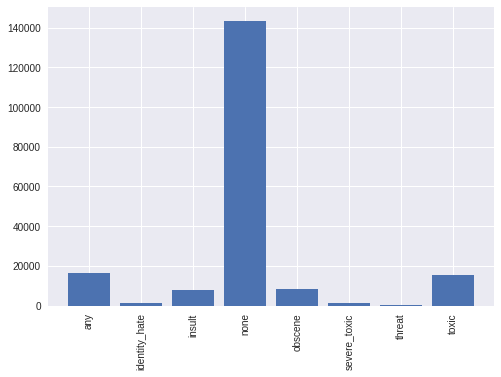

In [10]:
# Find number of comments of each label
frequencies = train[labels].sum(axis=0)
frequencies['none'] = len(train) - frequencies['any']

plt.clf()
x = np.array(frequencies)
plt.bar(labels + ['none'], height= x)
plt.xticks(rotation=90)
plt.show()

del frequencies

Even when we consider the number of comments that are bad in some way or the other (i.e. *'any'*), it pales in comparison to the number of good comments. **If we leave our training data like this, it will probably result in poor performance classifying bad comments.**

Another observation we can make is that the number of comments in *'any'* is very close to that in, say, *'toxic'*. This means that, from fundamental set theory (or just common sense), many comments belong to more than one category (otherwise, the number of comments in each category would add up to those in *'any'*).


---


Before we proceed to the step that preceeds building the actual model, let's compare the sentiment scores of good and bad comments of each category, just as a sanity check. It would be very surprising if our results did not conclude that bad comments had a significantly lower sentiment score in any category. Once again, we'll use an independent t-test under the assumption that the variances of both populations are the same.

We'll use *textblob*, which computes sentiment scores using a pretrained model. It can be seen [here](https://github.com/sloria/TextBlob/blob/90cc87ab0f9e25f37379079840ec43aba59af440/textblob/en/sentiments.py) that *textblob*'s model was trained upon a preclassified movie review corpus.

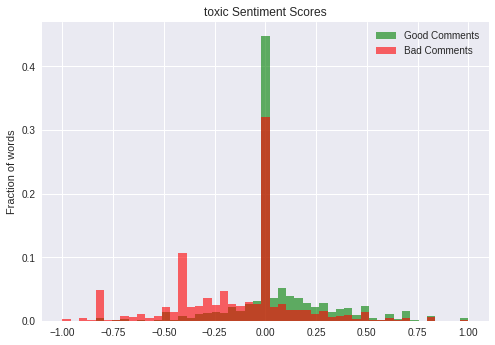

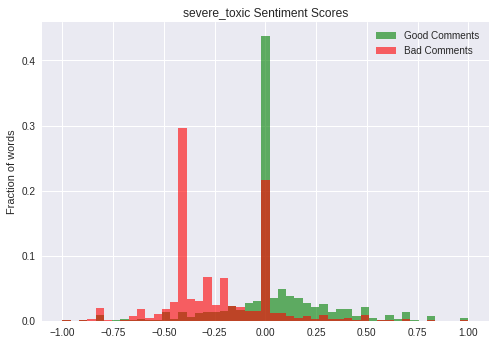

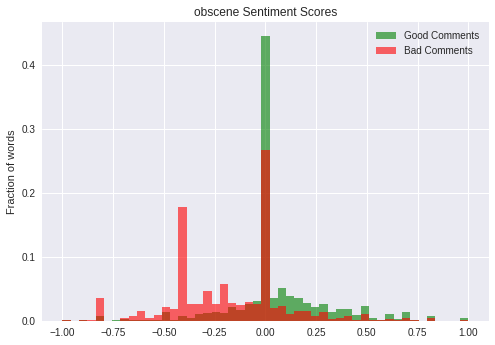

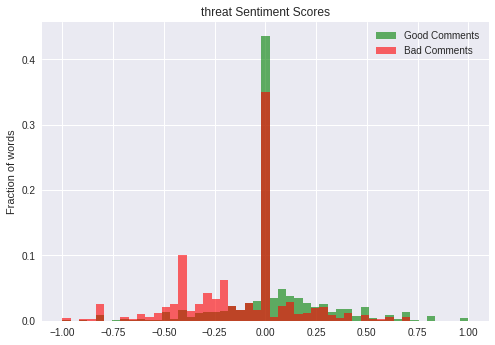

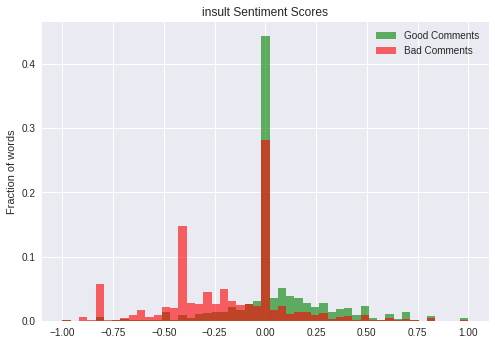

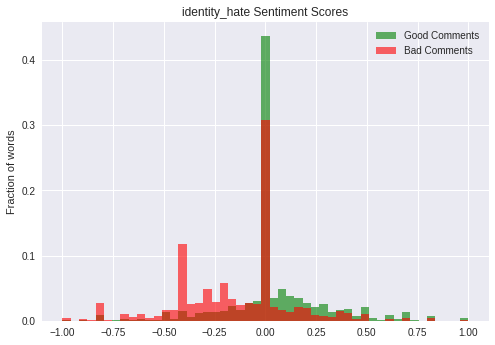

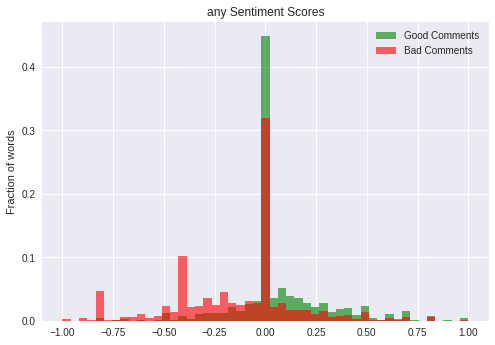

Is the p-value less than 0.05 - {'toxic': True, 'severe_toxic': True, 'obscene': True, 'threat': True, 'insult': True, 'identity_hate': True, 'any': True}


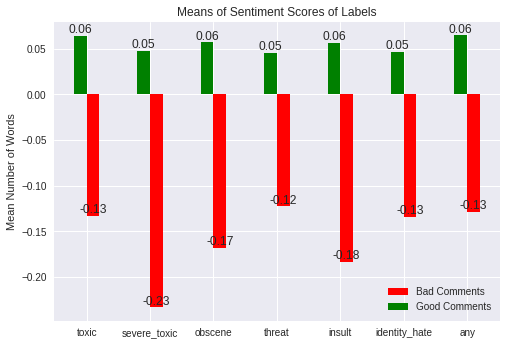

In [11]:
# Find mean sentiment scores for good/bad comments of each category
train['sentiment'] = train['comment_text'].apply(lambda x: TextBlob(x).sentiment.polarity) # we aren't using the pipeline because we don't want to scale
goodMeans, badMeans = [], []
pVals = {}
for label in labels:
    good = train[train[label] == 0]
    bad = train[train[label] == 1]
    t, p = ttest_ind(good['sentiment'], bad['sentiment'])
    pVals[label] = p < 0.05
    plot_double_dist(-1, 1, np.array(good['sentiment']), np.array(bad['sentiment']), '{} Sentiment Scores'.format(label))
    goodMeans.append(good['sentiment'].mean())
    badMeans.append(bad['sentiment'].mean())

print('Is the p-value less than 0.05 - {}'.format(pVals))
plot_double_bar(goodMeans, badMeans, 'Means of Sentiment Scores of Labels')

As we expected, all categories have a positive mean sentiment score for good comments, and a negative mean sentiment score for bad comments. An observation can be made that, consistently, around 45% of good comments and 20%-35% of bad comments' sentiment values are quite close to 0. **Every category has a p-value of less than 0.05, so this is definitely a valuable feature for our model.**


---


We need some way to represent each comment so it can be understood by a classification algorithm. The standard for doing so is still represting text in the form of tf-idf vectors. We will consider tf-idf vectors, number of words and sentiment score as the features for each comment. We'll use the feature pipeline we built to make tf-idf vectors, compute the scaled number of words and compute the scaled sentiment score as our features.

Note that we are fitting the pipeline on our train set, and using that model to generate vectors for the test dataset. This is because of the tf-idf vectors. That is, our test dataset shouldn't have any effect on the term frequencies of any word-document pair or the document frequencies of any word. We'll also remove *'any'* from our list of labels, because we don't need a model for it.

In [12]:
X_train = featurePipeline.fit_transform(train)
print('Processed Train set has a shape of: {}'.format(X_train.get_shape()))

# Note that we are not using fit_transform(), because we want our vectors to be in the space of our train data.
X_test = featurePipeline.transform(test)

if 'any' in labels:
    labels.remove('any')

Processed Train set has a shape of: (159571, 300002)


Now that we've made feature representations of all our comments, let's build a model for each category.

For each category we will first oversample bad comments using a technique called SMOTE. At the end of oversampling, we should have an equal number datapoints of each class (i.e. same number of good and bad comments, with some bad comments present multiple times in our training dataset).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from time import time
from imblearn.over_sampling import SMOTE

submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/knoesis/prog_task/sample_submission.csv')

for label in labels:
    y_train = train[label]

    print('LABEL {} ****************'.format(label))
    print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
    print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
    t1 = time()
    sm = SMOTE()
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    t2 = time()
    print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
    print('Time taken to OverSample = {}s'.format(t2-t1))
    
    t1 = time()
    model = LogisticRegression(solver = 'sag')
    # model = ComplementNB()
    model.fit(X_train_res, y_train_res)
    t2 = time()
    print('Time taken to train model = {}'.format(t2-t1))
    
    print('Confusion Matrix for Train:')
    y_pred_train = model.predict(X_train)
    y_pred_train = y_pred_train > 0
    print(confusion_matrix(y_train, y_pred_train))
    
    submission[label] = model.predict(X_test)
    
    print('**********************************************')

# submission[labels] = submission[labels] > 0.5
submission.to_csv('/content/drive/My Drive/Colab Notebooks/knoesis/prog_task/submission.csv')

LABEL toxic ****************
Before OverSampling, counts of label '1': 15294
Before OverSampling, counts of label '0': 144277
After OverSampling, counts of label '1': 144277
After OverSampling, counts of label '0': 144277
Time taken to OverSample = 328.63670349121094s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Time taken to train model = 54.79557681083679
Confusion Matrix for Train:
[[137056   7221]
 [  1063  14231]]
**********************************************
LABEL severe_toxic ****************
Before OverSampling, counts of label '1': 1595
Before OverSampling, counts of label '0': 157976
After OverSampling, counts of label '1': 157976
After OverSampling, counts of label '0': 157976
Time taken to OverSample = 376.9296259880066s
Time taken to train model = 54.64852237701416
Confusion Matrix for Train:
[[154735   3241]
 [     1   1594]]
**********************************************
LABEL obscene ****************
Before OverSampling, counts of label '1': 8449
Before OverSampling, counts of label '0': 151122
After OverSampling, counts of label '1': 151122
After OverSampling, counts of label '0': 151122
Time taken to OverSample = 349.7981343269348s
Time taken to train model = 56.47143507003784
Confusion Matrix for Train:
[[147205   3917]
 [   251   8198]]
************************************

As we can see, for most categories, our model has acceptable performance, although it seems to throw many false positives. Interestingly, our model didn't converge for toxic, but converged for all others.